In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepgeo.dataset.data_augment as dtaug
import deepgeo.dataset.utils as dsutils 
import deepgeo.common.geofunctions as gf
import deepgeo.networks.model_builder as mb
import deepgeo.networks.loss_functions as lossf

reload(dtaug)
reload(dsutils)
reload(mb)
reload(gf)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepgeo.common.geofunctions' from '../src/deepgeo/common/geofunctions.py'>

# Load input Dataset

In [2]:
# DATA_DIR = os.path.join(os.path.abspath(os.path.dirname('__file__')), '../', 'data_real', 'generated')
network = 'unet'
DATA_DIR = '/home/raian/doutorado/Dados/generated'
# DATASET_FILE = os.path.join(DATA_DIR, 'new_dataset_286x286_timesstack-2013-2017.npz')
DATASET = os.path.join(DATA_DIR, 'dataset_286x286_def_one_class_timestack_SR-2014-2017')

class_names = ['no data', 'not deforestation', 'deforestation', 'clouds']
# model_dir = os.path.join(DATA_DIR, 'tf_logs', network,
#                          'test_%s_%s' % (network, datetime.now().strftime('%d_%m_%Y-%H_%M_%S')))
# model_dir = os.path.join(DATA_DIR, 'tf_logs', 'experiments', network, 'test_unet_2019_07_01-20_14_34')
train_tfrecord = os.path.join(DATASET, 'dataset_train.tfrecord')
test_tfrecord = os.path.join(DATASET, 'dataset_test.tfrecord')
val_dataset = os.path.join(DATASET, 'dataset_valid.npz')

In [3]:
model_dir = '/home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug'
!rm -rf {model_dir}/*
!ls -al {model_dir}

total 8
drwxr-xr-x 2 raian digits 4096 Jul  9 18:56 .
drwxr-xr-x 3 raian digits 4096 Dec  7  2018 ..


## Computing weights

In [4]:
weights_train = lossf.compute_weights_inv_squared_proportion(train_tfrecord, class_names, ['no data'])
weights_eval = lossf.compute_weights_inv_squared_proportion(test_tfrecord, class_names, ['no data'])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
print(weights_train)
print(weights_eval)

[18.831877954940715, 4.926635606832914, 17.03875260959996, 169.6670236811928]
[20.059290754384325, 4.971656564272028, 15.993038904793188, 163.59723489617073]


In [6]:
params = {
    'network': network,
    'fusion': 'early',
    'epochs': 1,
    'batch_size': 20,
    'chip_size': 286,
    'bands': 10,
    'filter_reduction': 0.5,
    'learning_rate': 0.1,
    'learning_rate_decay': True,
    'decay_rate': 0.95 ,
    'l2_reg_rate': 0.0005,
    # 'var_scale_factor': 2.0,  # TODO: Put the initializer as parameter
    'chips_tensorboard': 2,
    # 'dropout_rate': 0.5,  # TODO: Put a bool parameter to apply or not Dropout
    'loss_func': 'avg_generalized_dice',
    'data_aug_ops': ['rot90', 'rot180', 'rot270', 'flip_left_right',
                     'flip_up_down', 'flip_transpose'],
    'data_aug_per_chip': 4,
    'class_weights': {'train': weights_train, 'eval': weights_eval},
    'num_classes': len(class_names),
    'class_names': class_names,
    'num_cofrom mpositions': 2,
    'bands_plot': [[1, 2, 3], [6, 7, 8]],
    'Notes': 'Testing.'
}

# Train the Network

In [7]:
reload(mb)
model = mb.ModelBuilder(params)

In [9]:
model.train(train_tfrecord, test_tfrecord, model_dir)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:2
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:3
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Configured nccl all-reduce.
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not usin

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug/model.ckpt-295
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
UNIQUE Predictions:  [0 1 2 3]
<<------------------------------------------------------------>>
<<------------------ Validation Results ---------------------->>
<<------------------------------------------------------------>>
F1-Score:
  - not deforestation: 0.9070987451334704
  - deforestation: 0.8504559651642615
  - clouds: 0.724332574893856
Precision:
  - not deforestation: 0.8546630279536862
  - deforestation: 0.9232152303642084
  - clouds: 0.878163080722663

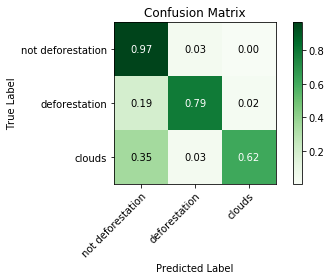

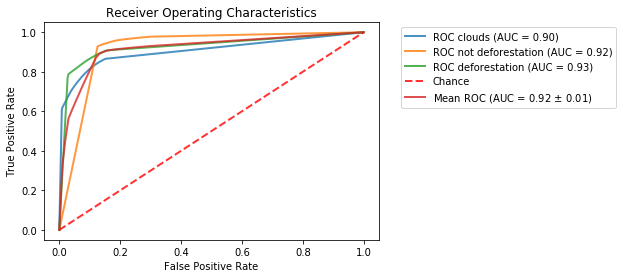

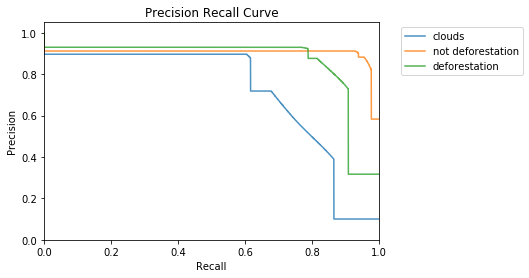

In [10]:
dataset = np.load(val_dataset)
model.validate(dataset['chips'], dataset['labels'], model_dir)